In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU (this may not be needed on your computer)

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=''

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=''


### load packages

In [3]:
from tfumap.umap import tfUMAP

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import umap
import pandas as pd

In [5]:
from tfumap.umap import tfUMAP

### Load dataset

In [6]:
from tfumap.paths import ensure_dir, MODEL_DIR, DATA_DIR

In [7]:
#dataset_address = 'http://file.biolab.si/opentsne/macosko_2015.pkl.gz'
# https://opentsne.readthedocs.io/en/latest/examples/01_simple_usage/01_simple_usage.html
# also see https://github.com/berenslab/rna-seq-tsne/blob/master/umi-datasets.ipynb

In [8]:
import gzip
import pickle

with gzip.open(DATA_DIR / 'macosko_2015.pkl.gz', "rb") as f:
    data = pickle.load(f)

x = data["pca_50"]
y = data["CellType1"].astype(str)

In [9]:
print("Data set contains %d samples with %d features" % x.shape)

Data set contains 44808 samples with 50 features


In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=.1, random_state=42)

In [12]:
np.shape(X_train)

(40327, 50)

In [13]:
n_valid = 10000
X_valid = X_train[-n_valid:]
Y_valid = Y_train[-n_valid:]
X_train = X_train[:-n_valid]
Y_train = Y_train[:-n_valid]

In [14]:
X_train_flat = X_train

In [15]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()

In [16]:
Y_train = enc.fit_transform([[i] for i in Y_train]).flatten()

### Create model and train

In [17]:
embedder = tfUMAP(n_components= 64,direct_embedding=True, verbose=True, negative_sample_rate=5, training_epochs=100)

In [18]:
z = embedder.fit_transform(X_train_flat)

tfUMAP(direct_embedding=True, negative_sample_rate=5,
       optimizer=<tensorflow.python.keras.optimizer_v2.adadelta.Adadelta object at 0x7f01b163c390>,
       tensorboard_logdir='/tmp/tensorboard/20200714-111922',
       training_epochs=100)
Construct fuzzy simplicial set
Tue Jul 14 11:19:22 2020 Finding Nearest Neighbors
Tue Jul 14 11:19:22 2020 Building RP forest with 14 trees
Tue Jul 14 11:19:24 2020 parallel NN descent for 15 iterations
	 0  /  15
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	 5  /  15
Tue Jul 14 11:19:36 2020 Finished Nearest Neighbor Search
Tue Jul 14 11:19:49 2020 Embedding with TensorFlow


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Tue Jul 14 12:10:34 2020 Finished embedding


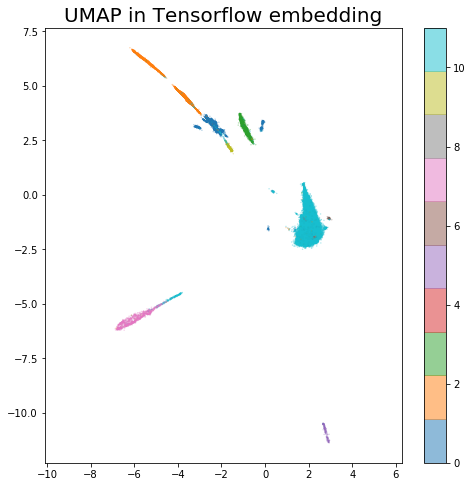

In [19]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_train,
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

### View loss

In [20]:
from tfumap.umap import retrieve_tensors
import seaborn as sns

In [21]:
loss_df = retrieve_tensors(embedder.tensorboard_logdir)
loss_df[:3]

['umap_loss']
[]


,wall_time,step,val,group,variable
0,1.594751e+09,1,0.407699,train,umap_loss
1,1.594751e+09,2,0.360970,train,umap_loss
2,1.594751e+09,3,0.338835,train,umap_loss


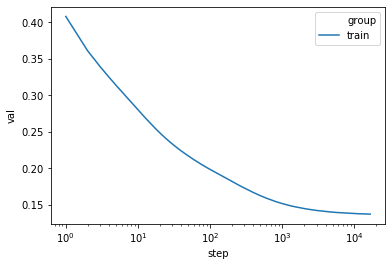

In [22]:
ax = sns.lineplot(x="step", y="val", hue="group", data=loss_df[loss_df.variable=='umap_loss'])
ax.set_xscale('log')

### Save output

In [23]:
from tfumap.paths import ensure_dir, MODEL_DIR

In [24]:
output_dir = MODEL_DIR/'projections'/ 'macosko2015' / '64'/ 'direct'
ensure_dir(output_dir)

In [25]:
embedder.save(output_dir)

Pickle of model saved


In [26]:
loss_df.to_pickle(output_dir / 'loss_df.pickle')

In [27]:
np.save(output_dir / 'z.npy', z)